# Read in the data

In [1]:
import pandas
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Index(['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11',
       'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'aca_t_11', 'saf_s_11',
       'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11',
       'eng_tot_11', 'aca_tot_11'],
      dtype='object')


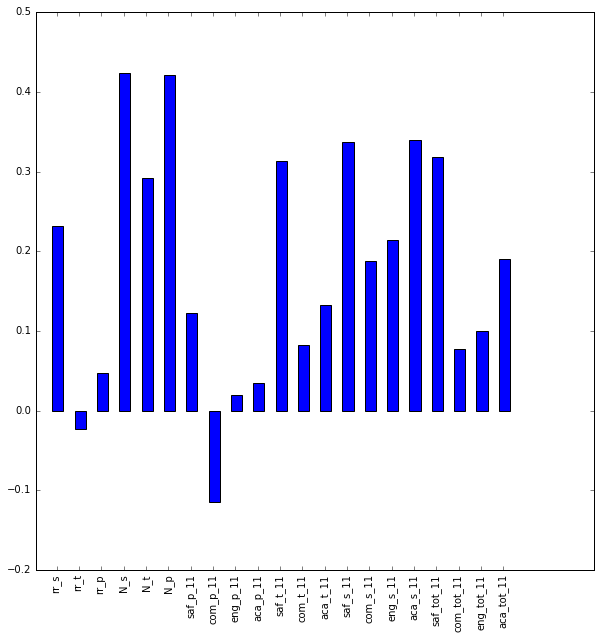

In [10]:
survey_corr = correlations[survey_fields]
survey_nums = survey_corr[numpy.isnan(survey_corr.values)==False]
print(survey_nums.index)

plt.figure(figsize=(10,10))
bar_heights = survey_nums.values
bar_positions = numpy.arange(len(bar_heights)) + 0.75
plt.bar(bar_positions,bar_heights, 0.5)
plt.xticks(bar_positions +.2,survey_nums.index,rotation='vertical')
plt.show()

<h1> WRITE ABOUT THE ABOVE CORRELATIONS HERE AFTER DOWNLOADING DATA </h1>

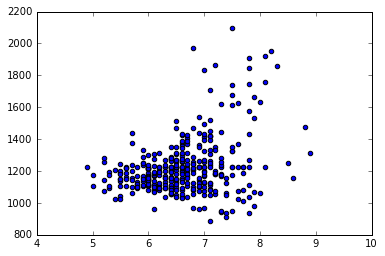

In [11]:
plt.scatter(combined['saf_s_11'],combined['sat_score'])

From above, it seems clear that a higher safety score is necessary but not sufficient for high SAT scores. (i.e. Only safer schools (above 6.75ish) scored well on the SAT, but plenty of safer schools still scored poorly.)

In [12]:
print(combined.columns.values)

['DBN' 'SCHOOL NAME' 'Num of SAT Test Takers'
 'SAT Critical Reading Avg. Score' 'SAT Math Avg. Score'
 'SAT Writing Avg. Score' 'sat_score' 'SchoolName' 'AP Test Takers '
 'Total Exams Taken' 'Number of Exams with scores 3 4 or 5' 'Demographic'
 'School Name' 'Cohort' 'Total Cohort' 'Total Grads - n'
 'Total Grads - % of cohort' 'Total Regents - n'
 'Total Regents - % of cohort' 'Total Regents - % of grads'
 'Advanced Regents - n' 'Advanced Regents - % of cohort'
 'Advanced Regents - % of grads' 'Regents w/o Advanced - n'
 'Regents w/o Advanced - % of cohort' 'Regents w/o Advanced - % of grads'
 'Local - n' 'Local - % of cohort' 'Local - % of grads'
 'Still Enrolled - n' 'Still Enrolled - % of cohort' 'Dropped Out - n'
 'Dropped Out - % of cohort' 'CSD' 'NUMBER OF STUDENTS / SEATS FILLED'
 'NUMBER OF SECTIONS' 'AVERAGE CLASS SIZE' 'SIZE OF SMALLEST CLASS'
 'SIZE OF LARGEST CLASS' 'SCHOOLWIDE PUPIL-TEACHER RATIO' 'Name'
 'schoolyear' 'fl_percent' 'frl_percent' 'total_enrollment' 'prek'

school_dist
01    6.768611
02    6.910660
03    6.716667
04    6.885714
05    6.314286
06    6.950000
07    6.800000
08    6.364697
09    6.655000
10    6.577273
11    6.186667
12    7.116667
13    6.407692
14    6.685714
15    6.177778
16    5.875000
17    6.007143
18    6.190909
19    6.150000
20    7.120000
21    6.390909
22    7.025000
23    6.233333
24    7.107692
25    6.912500
26    6.760000
27    6.390000
28    6.627273
29    6.075000
30    7.033333
31    6.530000
32    6.766667
Name: saf_s_11, dtype: float64 school_dist
01   -73.982377
02   -73.991386
03   -73.977370
04   -73.943215
05   -73.949251
06   -73.932502
07   -73.919971
08   -73.866087
09   -73.906240
10   -73.898360
11   -73.856120
12   -73.886946
13   -73.977016
14   -73.948360
15   -73.989255
16   -73.929686
17   -73.955636
18   -73.914726
19   -73.882158
20   -74.006191
21   -73.978465
22   -73.952288
23   -73.912298
24   -73.911518
25   -73.815558
26   -73.759176
27   -73.807823
28   -73.806367
29   -73.752740
3

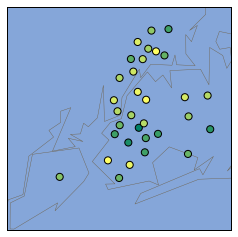

In [13]:
from mpl_toolkits.basemap import Basemap
districts = combined.groupby('school_dist')
districts = districts.agg(numpy.mean)
print(districts['saf_s_11'],districts['lon'])
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,c = districts['saf_s_11'],cmap="summer")
plt.show()

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64


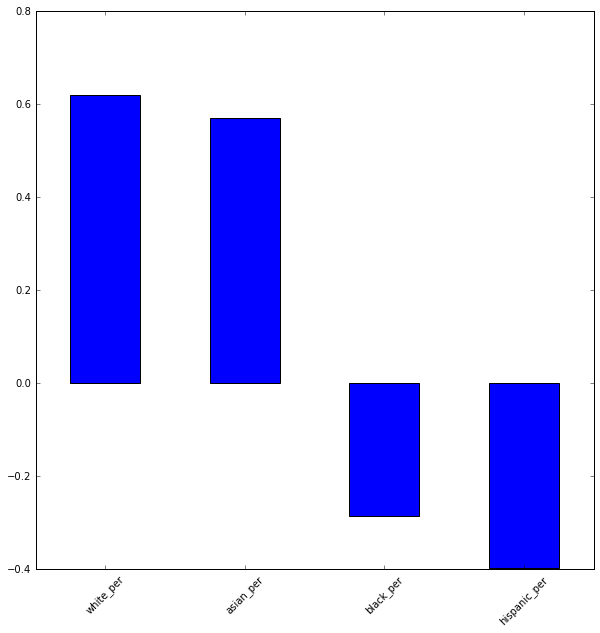

In [14]:
race_res = ['white_per','asian_per','black_per','hispanic_per']
race_corr = correlations[race_res]
print(race_corr)

plt.figure(figsize=(10,10))
bar_heights = race_corr.values
bar_positions = numpy.arange(len(bar_heights)) + 0.75
plt.bar(bar_positions,bar_heights, 0.5)
plt.xticks(bar_positions + (.5/2),race_corr.index,rotation=45)
plt.show()

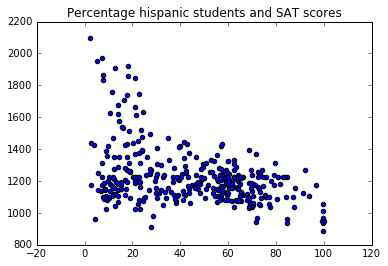

In [28]:
hispanic_cor = combined['hispanic_per']
over_75_black = combined[combined['black_per'] > 50]
over_75_asian = combined[combined['asian_per'] > 50]
over_75_white = combined[combined['white_per'] > 50]
plt.scatter(hispanic_cor,combined['sat_score'])
plt.title('Percentage hispanic students and SAT scores')
#plt.scatter(over_75_black['black_per'],over_75_black['sat_score'])

44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object


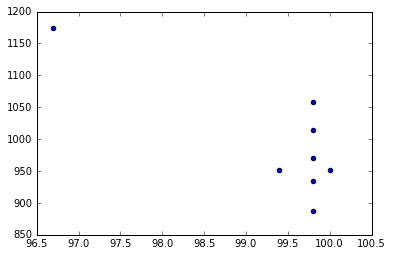

In [23]:
hisp_95 = combined[combined['hispanic_per'] > 95]
plt.scatter(hisp_95['hispanic_per'],hisp_95['sat_score'])
print(hisp_95['school_name'])

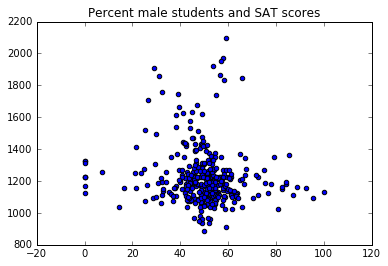

In [29]:
males = combined['male_per']
females = combined['female_per']
plt.scatter(males,combined['sat_score'])
plt.title("Percent male students and SAT scores")

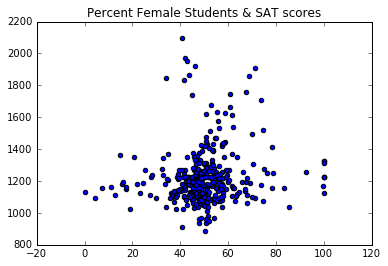

In [30]:
plt.scatter(females,combined['sat_score'])
plt.title("Percent Female Students & SAT scores")

It seems like schools with an even distribution of male/female students did best on the SAT

In [33]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment'] * 100

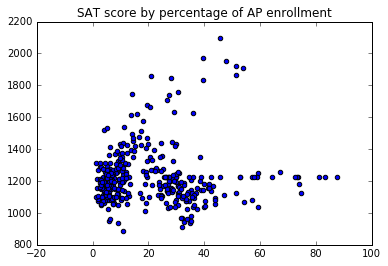

In [34]:
plt.scatter(combined['ap_per'],combined['sat_score'])
plt.title('SAT score by percentage of AP enrollment')

Again, a mix of students is good. The schools with moderate AP enrollment (40-60 percent) had the highest SAT scores

<h2> Other points of investigation </h2>
<li> Determining whether there's a correlation between class size and SAT scores </li>
<li> Figuring out which neighborhoods have the best schools
<li> If we comine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools </li> 
</li>
<li> Investigating the differences between parent, teacher, and student responses to surveys </li>
<li> Assigning scores to schools based on `sat_score` and other attributes</li>